<a href="https://colab.research.google.com/github/tuggcebolat/AI-Data-Science-Projects/blob/main/GANs_on_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Model,Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,ReLU,Reshape,Input
from keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.datasets import mnist

In [2]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train=(x_train.astype(np.float32)-127.5)/127.5
print(x_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [3]:
#to make the pixel 784
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
print(x_train.shape)

(60000, 784)


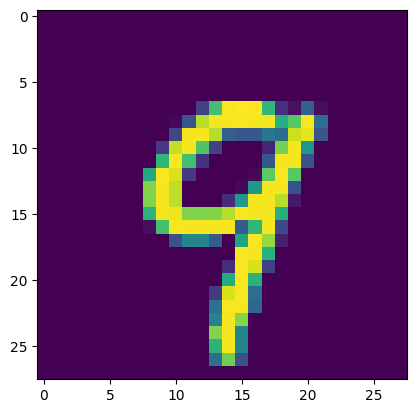

In [4]:
plt.imshow(x_test[12])

## Create Generator

In [5]:

def create_generator():
    generator = Sequential()
    generator.add(Dense(units=512, input_dim=100))
    generator.add(ReLU())

    generator.add(Dense(units=512))
    generator.add(ReLU())

    generator.add(Dense(units=1024))
    generator.add(ReLU())

    generator.add(Dense(units=784, activation="tanh"))
    generator.compile(loss="binary_crossentropy",
                      optimizer=Adam(learning_rate=0.0001, beta_1=0.5))
    return generator

g = create_generator()
g.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 re_lu_1 (ReLU)              (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_2 (ReLU)              (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

In [6]:
#discriminator
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=1024, input_dim=784))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))

    discriminator.add(Dense(units=512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))

    discriminator.add(Dense(units=256))
    discriminator.add(ReLU())

    discriminator.add(Dense(units=1, activation="sigmoid"))

    discriminator.compile(loss="binary_crossentropy",
                          optimizer=Adam(learning_rate=0.0001, beta_1=0.5))
    return discriminator

d = create_discriminator()
d.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 re_lu_3 (ReLU)              (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 re_lu_4 (ReLU)              (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

## GANs

In [7]:
def create_gan(discriminator,generator):
    discriminator.trainable=False
    gan_input =Input(shape=(100,))
    x=generator(gan_input)
    gan_output=discriminator(x)
    gan=Model(inputs=gan_input,outputs=gan_output)
    gan.compile(loss="binary_crossentropy",optimizer="adam")
    return gan
gan =create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1643280   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 3103505 (11.84 MB)
Trainable params: 1643280 (6.27 MB)
Non-trainable params: 1460225 (5.57 MB)
_________________________________________________________________


In [11]:
#train
epochs =50 #50
batch_size=256
for e in range(epochs):
    for  _ in range(batch_size):
        noise =np.random.normal(0,1,[batch_size,100])
        generated_images =g.predict(noise)
        image_batch =x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]

        x=np.concatenate([image_batch,generated_images])

        y_dis=np.zeros(batch_size*2)
        y_dis[:batch_size]=1

        d.trainable=True
        d.train_on_batch(x,y_dis)
        noise=np.random.normal(0,1,[batch_size,100])

        y_gen =np.ones(batch_size)
        d.trainable=False
        gan.train_on_batch(noise,y_gen)
    print("epochs: ",e)



Görüntülenen çıkış son 5000 satıra kısaltıldı.
8/8 [==============================] - 0s 8ms/step
epochs:  30
8/8 [==============================] - 0s 7ms/step
epochs:  31
8/8 [==============================] - 0s 8ms/step
epochs:  32
8/8 [==============================] - 0s 8ms/step
epochs:  33
8/8 [==============================] - 0s 8ms/step
epochs:  34
8/8 [==============================] - 0s 7ms/step
epochs:  35
8/8 [==============================] - 0s 8ms/step
epochs:  36
8/8 [==============================] - 0s 6ms/step
epochs:  37
8/8 [==============================] - 0s 10ms/step
epochs:  38
8/8 [==============================] - 0s 8ms/step
epochs:  39
8/8 [==============================] - 0s 8ms/step
epochs:  40
8/8 [==============================] - 0s 9ms/step
epochs:  41
8/8 [==============================] - 0s 8ms/step
epochs:  42
8/8 [==============================] - 0s 9ms/step
epochs:  43
8/8 [==============================] - 0s 8ms/step
epochs:  44
8/8 [==

In [14]:
#Save Model
g.save_weights("gans_model.weights.h5")



4/4 [==============================] - 0s 6ms/step


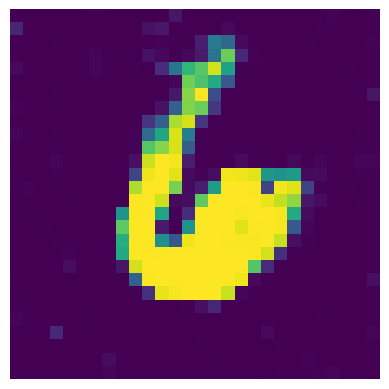

In [15]:
#visualize
noise=np.random.normal(loc=0,scale=1,size=[100,100])
generated_images=g.predict(noise)
generated_images=generated_images.reshape(100,28,28)
plt.imshow(generated_images[66],interpolation="nearest")
plt.axis("off")
plt.show()